# Scan MERRA-2 atmospheric properties during one Year
------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation January 12th 2017


Link:

http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release

### purpose:

Scan One year of MERRA-2 predictions of the dataset tavg1_2d_csp_Nx_M2T1NXCSP. 
Extract the relevant atmospheric variables.
Build the correcponding time series and dataset in pandas.
Plot the variables. Save the pandas dataset into a file.
Convert the pandas dataset into an astropy fits table and save into a fits file as well.



## 1) python libraries
---------------------------

In [1]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

/Users/dagoret-campagnesylvie/.local/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import datetime

In [3]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [4]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [5]:
import os
import re
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table

In [7]:
import h5py

In [8]:
import libGMAOMERRA2Data as merra2  # My own library

In [9]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 2)  Configuration
-------------------------

In [10]:
# SELECT OBSERVATORY
OBS_NAME='ohp'

In [11]:
# where are the HDF files
#HDFEOS_ZOO_DIR="/Volumes/DAGORETBACK/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM/2016"
HDFEOS_ZOO_DIR="/Volumes/LaCie2/DATA/MERRA-2/tavg1_2d_csp_Nx_M2T1NXCSP"

In [12]:
path=HDFEOS_ZOO_DIR

### Here I describe the content of the input files

In [13]:
DATA_TAG=['ISCCPCLDFRC','MDSH2OPATH','MDSICEPATH','MDSOPTHCKH2O','MDSOPTHCKICE','MDSOPTHCKTTL']

In [14]:
DATA_TITLE=['ISCCP Cloud area fraction',
            'MODIS H2O path',
            'MODIS ice path',
            'MODIS H2O optical thickness',
            'MODIS ice optical thickness',
            'MODIS total optical thickness'
           ]

In [15]:
NB_DATAFIELDS=len(DATA_TAG)

### List of output files

In [16]:
# The selected data field
DATA_NAME =  'tavg1_2d_csp_Nx_M2T1NXCSP'   # 

In [17]:
pandas_filename='MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'.csv'

In [18]:
fits_filename='MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear' +'.fits'

In [19]:
# 6 output files for figures
figfile_odh2omean='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_odh2omean'+'.jpg'
figfile_odicemean='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_odicemean'+'.jpg'
figfile_odtotmean='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_odtotmean'+'.jpg'

figfile_thh2omean='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_thh2omean'+'.jpg'
figfile_thicemean='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_thicemean'+'.jpg'

figfile_cldfrac='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_cldfrac'+'.jpg'

### Select where in the world

In [20]:
# Select observatory
loc=merra2.observatory_location(OBS_NAME)

In [21]:
loc

(5.71222222222, 43.9316666667, 650.0)

### 2.2) Getting the list of the files
------------------------------

In [22]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  

In [23]:
nc4_files[:5]

['MERRA2_400.tavg1_2d_csp_Nx.20160101.nc4',
 'MERRA2_400.tavg1_2d_csp_Nx.20160102.nc4',
 'MERRA2_400.tavg1_2d_csp_Nx.20160103.nc4',
 'MERRA2_400.tavg1_2d_csp_Nx.20160104.nc4',
 'MERRA2_400.tavg1_2d_csp_Nx.20160105.nc4']

### 2.3) Select files of a given month

In [24]:
keysel_filename='^MERRA2_400.tavg1_2d_csp_Nx.2016.*'

In [25]:
print 'Selection key' ,keysel_filename

Selection key ^MERRA2_400.tavg1_2d_csp_Nx.2016.*


In [26]:
nc4_files2 = []
for file in nc4_files:
    if re.findall(keysel_filename,file):
        nc4_files2.append(file)

nc4_files2=np.array(nc4_files2)

In [27]:
nc4_files2

array(['MERRA2_400.tavg1_2d_csp_Nx.20160101.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160102.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160103.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160104.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160105.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160106.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160107.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160108.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160109.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160110.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160111.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160112.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160113.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160114.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160115.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160116.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160117.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160118.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160119.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20160120.nc4',


### 2.4) Sort files by increasing time

In [28]:
nc4_files=np.sort(nc4_files2)

### 2.5) Build the full filename before reading

In [29]:
NBFILES=len(nc4_files)
full_nc4files=[]

for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4files.append(fname)  

## 3)  Extract data and write them into pandas dataset and time series
--------------------------------------------------------------------------------------

In [30]:
clf_timeseries=[] # example of time series for cloud fraction for test
ts0=[]  # intermediate data series
ts1=[]
ts2=[]
ts3=[]
ts4=[]
ts5=[]

df_tavg1_2d_csp_Nx=[] # final pandas dataset for all atmospheric quantities

for file in full_nc4files: # loop on data file of each day of the month
    
    #Retrieve 1D parameters longitude, latitude, time
    (m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(file,'lat') # latitude (array, unit, name)
    m_latitude = m_lat[:]
    (m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(file,'lon') # longitude(array, unit, name)
    m_longitude = m_lon[:]
    (m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(file,'time') # time (array, unit, name)
    m_time=m_tim[:]
       
    NbDataPerFile=m_time.shape[0] # number of data sample per file
    #start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",m_un_tim) # extract start time
    start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)",m_un_tim) # extract start time
    
    #print 'start_time = ', start_time
    time_rng = pd.date_range(start_time[0], periods=NbDataPerFile, freq='H') # one data per hour
    
    print 'start_time = ', start_time
    
    m_X,m_Y=np.meshgrid(m_longitude,m_latitude) # build meash-grid in longitude and latitude
    (sel_long, sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1]) # get bin in longitude and latitude for the site  
    
    # isccp cloud area fraction
    (m_clf_data,m_clf_unit,m_clf_longname)=merra2.GetGeoRefData(file,DATA_TAG[0]) # 3D array : time x longitude x latitude  
    clf=m_clf_data[:,sel_lat,sel_long]
    ts = pd.Series(clf, index=time_rng)
    clf_timeseries.append(ts)
 
    # loop
    for index in range(NB_DATAFIELDS):
        (m_data,m_unit,m_longname)=merra2.GetGeoRefData(file,DATA_TAG[index]) # 3D array : time x longitude x latitude  
        dt=m_data[:,sel_lat,sel_long]
        if index==0:
            ts0 = pd.Series(dt, index=time_rng)
        elif index==1:
            ts1 = pd.Series(dt, index=time_rng)
        elif index==2:
            ts2 = pd.Series(dt, index=time_rng)
        elif index==3:
            ts3 = pd.Series(dt, index=time_rng)
        elif index ==4:
            ts4 = pd.Series(dt, index=time_rng)
        elif index ==5:
            ts5 = pd.Series(dt, index=time_rng)
            
        #clf_timeseries.append(ts)
        # Create the dataframe
    df = pd.DataFrame({DATA_TAG[0]: ts0, 
                       DATA_TAG[1]: ts1,
                       DATA_TAG[2]: ts2,
                       DATA_TAG[3]: ts3,
                       DATA_TAG[4]: ts4,
                       DATA_TAG[5]: ts5 }, index=time_rng)
    df_tavg1_2d_csp_Nx.append(df)  
    

start_time =  ['2016-01-01 00:30:00']
start_time =  ['2016-01-02 00:30:00']
start_time =  ['2016-01-03 00:30:00']
start_time =  ['2016-01-04 00:30:00']
start_time =  ['2016-01-05 00:30:00']
start_time =  ['2016-01-06 00:30:00']
start_time =  ['2016-01-07 00:30:00']
start_time =  ['2016-01-08 00:30:00']
start_time =  ['2016-01-09 00:30:00']
start_time =  ['2016-01-10 00:30:00']
start_time =  ['2016-01-11 00:30:00']
start_time =  ['2016-01-12 00:30:00']
start_time =  ['2016-01-13 00:30:00']
start_time =  ['2016-01-14 00:30:00']
start_time =  ['2016-01-15 00:30:00']
start_time =  ['2016-01-16 00:30:00']
start_time =  ['2016-01-17 00:30:00']
start_time =  ['2016-01-18 00:30:00']
start_time =  ['2016-01-19 00:30:00']
start_time =  ['2016-01-20 00:30:00']
start_time =  ['2016-01-21 00:30:00']
start_time =  ['2016-01-22 00:30:00']
start_time =  ['2016-01-23 00:30:00']
start_time =  ['2016-01-24 00:30:00']
start_time =  ['2016-01-25 00:30:00']
start_time =  ['2016-01-26 00:30:00']
start_time =

### Concatenation

In [31]:
result = pd.concat(clf_timeseries)

In [32]:
df_tavg1_2d_csp_Nx=pd.concat(df_tavg1_2d_csp_Nx)

In [33]:
df_tavg1_2d_csp_Nx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8040 entries, 2016-01-01 00:30:00 to 2016-11-30 23:30:00
Data columns (total 6 columns):
ISCCPCLDFRC     4501 non-null float32
MDSH2OPATH      4501 non-null float32
MDSICEPATH      4501 non-null float32
MDSOPTHCKH2O    2692 non-null float32
MDSOPTHCKICE    2132 non-null float32
MDSOPTHCKTTL    3282 non-null float32
dtypes: float32(6)
memory usage: 251.2 KB


## 4) Plot the time dependence of time series and dataset

####  Fill information on years and months from the filenames

In [34]:
result = pd.concat(clf_timeseries)

In [35]:
def PlotTimeSeries(index,figfile):
    plt.figure(figsize=(20,5))
    df_tavg1_2d_csp_Nx[DATA_TAG[index]].plot(lw=3,color='red')
    plt.xlabel('time')
    plt.ylabel(DATA_TAG[index])
    title= "Hourly {} at {} in 2016/{}".format(DATA_TITLE[index],OBS_NAME,'AllYear')
    plt.title(title,fontsize=15)
    plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
    plt.grid(True)
    plt.savefig(figfile)

### 4.1) Cloud fraction

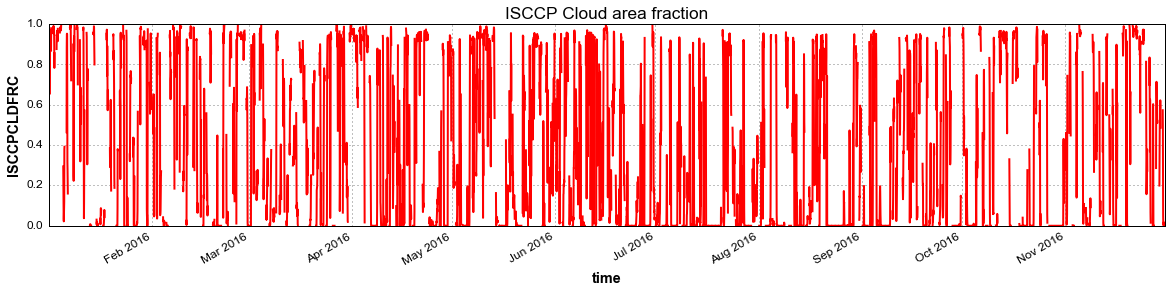

In [36]:
plt.figure(figsize=(20,4))
result.plot(grid=True,lw=2,color='red')
plt.xlabel('time')
plt.ylabel(DATA_TAG[0])
plt.title(DATA_TITLE[0])

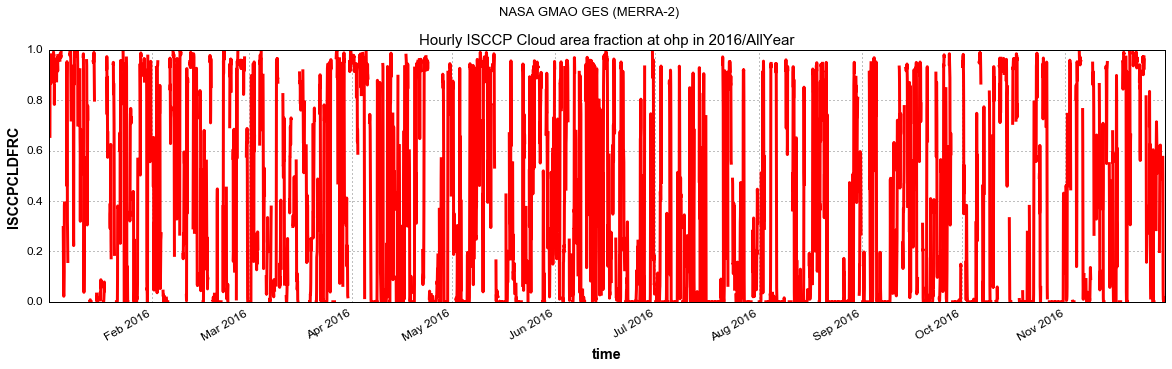

In [37]:
PlotTimeSeries(0,figfile_cldfrac)

###  4.2)  MODIS H2O Path Mean

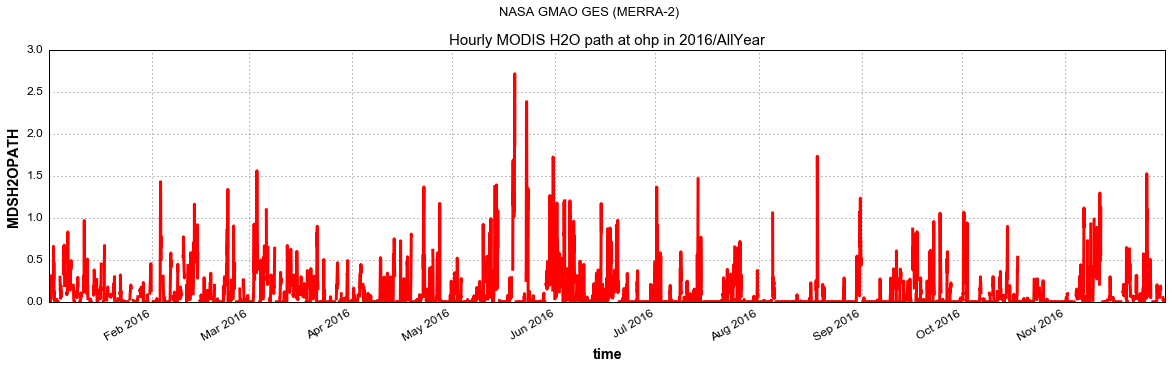

In [38]:
PlotTimeSeries(1,figfile_thh2omean)

### 4.3) MODIS Ice Path Mean

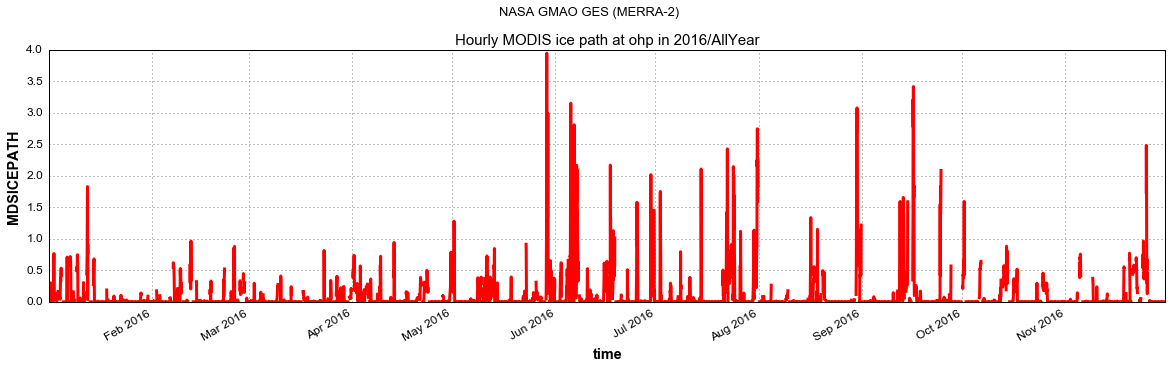

In [39]:
PlotTimeSeries(2,figfile_thicemean)

### 4.4) MODIS H2O Optical Depth

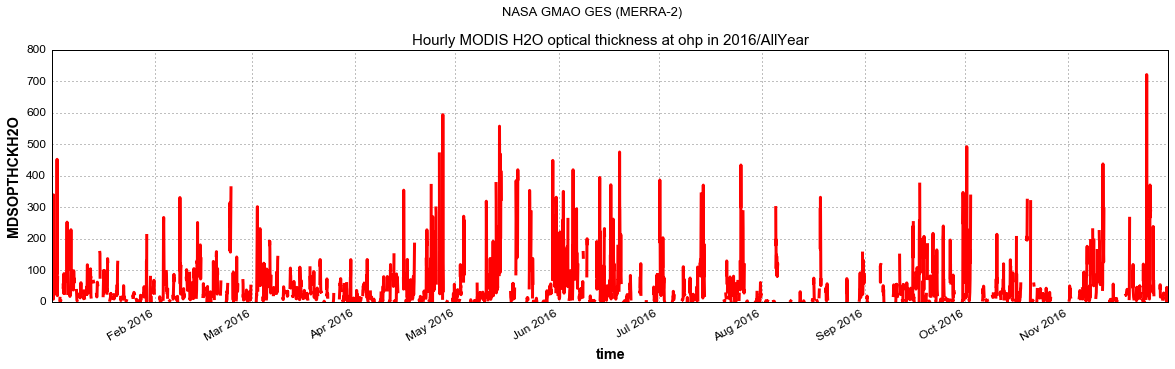

In [40]:
PlotTimeSeries(3,figfile_odh2omean)

### 4.5) MODIS Ice Optical Depth

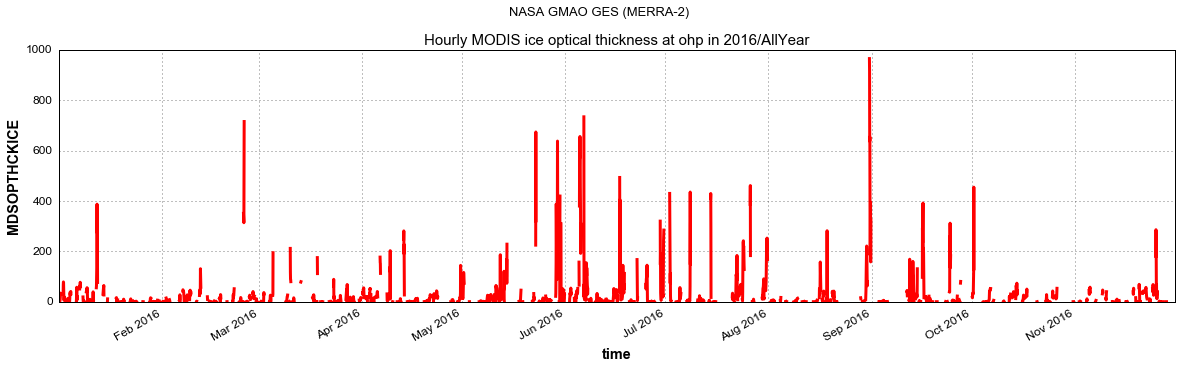

In [41]:
PlotTimeSeries(4,figfile_odicemean)

### 4.6) MODIS Total Optical Depth

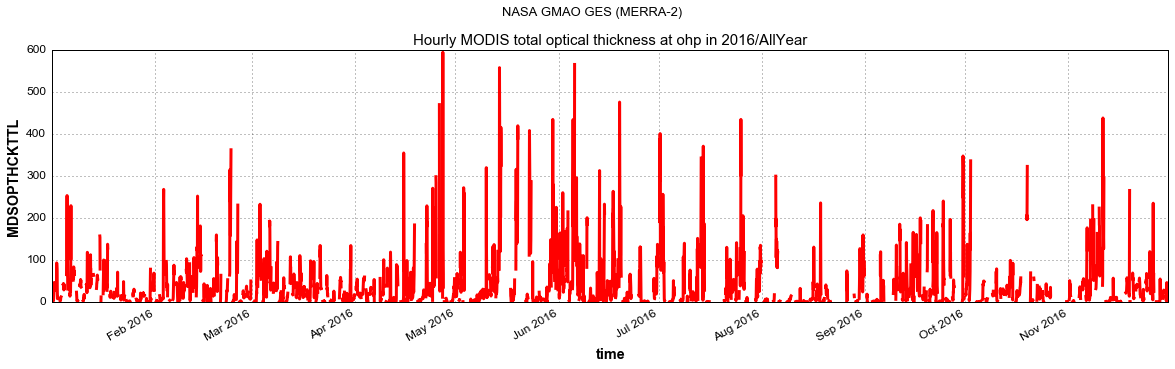

In [42]:
PlotTimeSeries(5,figfile_odtotmean)

## 5) Output

In [43]:
df_tavg1_2d_csp_Nx.index.name='time'
df_tavg1_2d_csp_Nx.describe()

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,ISCCPCLDFRC,MDSH2OPATH,MDSICEPATH,MDSOPTHCKH2O,MDSOPTHCKICE,MDSOPTHCKTTL
count,4501.000000,4501.000000,4501.000000,2692.000000,2132.000000,3282.000000
mean,0.376865,0.124122,0.120517,57.709110,38.404240,45.633335
std,0.382647,0.237628,0.325831,75.637112,86.264970,64.976205
min,0.000000,0.000000,0.000000,0.303246,0.302312,0.302744
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,1.000000,2.713345,3.946269,721.143616,964.956665,594.060120


## 5)  Save dataset  in file pandas (csv)
----------------------------------------

In [44]:
dataset=df_tavg1_2d_csp_Nx

In [45]:
dataset.index.name='time'

In [46]:
dataset.describe()

,ISCCPCLDFRC,MDSH2OPATH,MDSICEPATH,MDSOPTHCKH2O,MDSOPTHCKICE,MDSOPTHCKTTL
count,4501.000000,4501.000000,4501.000000,2692.000000,2132.000000,3282.000000
mean,0.376865,0.124122,0.120517,57.709110,38.404240,45.633335
std,0.382647,0.237628,0.325831,75.637112,86.264970,64.976205
min,0.000000,0.000000,0.000000,0.303246,0.302312,0.302744
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,1.000000,2.713345,3.946269,721.143616,964.956665,594.060120


In [47]:
dataset.head()

,ISCCPCLDFRC,MDSH2OPATH,MDSICEPATH,MDSOPTHCKH2O,MDSOPTHCKICE,MDSOPTHCKTTL
time,,,,,,
2016-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 03:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 04:30:00,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
dataset.to_csv(pandas_filename)

In [49]:
saved_dataset=pd.read_csv(pandas_filename)

In [50]:
saved_dataset.head()

,time,ISCCPCLDFRC,MDSH2OPATH,MDSICEPATH,MDSOPTHCKH2O,MDSOPTHCKICE,MDSOPTHCKTTL
0,2016-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01 03:30:00,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01 04:30:00,NaN,NaN,NaN,NaN,NaN,NaN


## 6) Convert dataset into a table and then save in a fits file
--------------------------------------------------------------------------

In [51]:
table = Table.from_pandas(saved_dataset)

In [52]:
table

time,ISCCPCLDFRC,MDSH2OPATH,MDSICEPATH,MDSOPTHCKH2O,MDSOPTHCKICE,MDSOPTHCKTTL
str19,float64,float64,float64,float64,float64,float64
2016-01-01 00:30:00,--,--,--,--,--,--
2016-01-01 01:30:00,--,--,--,--,--,--
2016-01-01 02:30:00,--,--,--,--,--,--
2016-01-01 03:30:00,--,--,--,--,--,--
2016-01-01 04:30:00,--,--,--,--,--,--
2016-01-01 05:30:00,--,--,--,--,--,--
2016-01-01 06:30:00,--,--,--,--,--,--
2016-01-01 07:30:00,0.656243145466,0.0161820203066,0.00268396665342,50.1113357544,0.461097955704,3.59428787231
2016-01-01 08:30:00,0.929823577404,0.000187754732906,0.0169364344329,8.0950088501,1.72810447216,1.72930550575


In [53]:
table.write(fits_filename,format='fits',overwrite=True)